In [46]:
# Import libraries
from openai import OpenAI
import pandas as pd
import numpy as np
import json
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from textstat import flesch_kincaid_grade
import matplotlib.pyplot as plt
import backoff  # For retry mechanism


# Section 1: Initialize OpenAI API

Set up the OpenAI API client with the new syntax (openai>=1.0.0).

In [73]:
# Load API key from open_key.txt
try:
    with open("openai_key.txt", "r") as key_file:
        api_key = key_file.read().strip()
    if not api_key:
        raise ValueError("open_key.txt is empty or missing API key.")
except FileNotFoundError:
    raise FileNotFoundError("open_key.txt not found. Please create it with your OpenAI API key.")

client = OpenAI(api_key=api_key)

In [58]:
# Define backoff for rate limit handling
@backoff.on_exception(backoff.expo, Exception, max_tries=5)
def call_openai(prompt, max_tokens=150, model="gpt-4o"):
    """Wrapper for OpenAI API (v1.0.0+) with retry for rate limits and reduced prompt size."""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=0.7
        )
        result = response.choices[0].message.content.strip()
        print(f"Prompt: {prompt[:50]}...")  # Log for tracking
        print(f"Response: {result}\n")
        return result
    except Exception as e:
        print(f"OpenAI API error: {e}")
        raise  # Re-raise for backoff to handle

# Section 2: Load and Analyze Synthea Dataset

Load synthetic data (including medications) and analyze diabetes prevalence.

In [59]:
def load_synthea_data():
    """Load Synthea CSV files, including medications."""
    try:
        patients = pd.read_csv("synthea/patients.csv")
        conditions = pd.read_csv("synthea/conditions.csv")
        observations = pd.read_csv("synthea/observations.csv")
        medications = pd.read_csv("synthea/medications.csv")
        return patients, conditions, observations, medications
    except FileNotFoundError as e:
        print(f"Error loading dataset: {e}")
        return None, None, None, None

patients, conditions, observations, medications = load_synthea_data()
if patients is None:
    raise SystemExit("Failed to load Synthea dataset.")

# Analyze diabetes prevalence and risk factors
diabetes_patients = conditions[conditions["DESCRIPTION"].str.lower().str.contains("diabetes")]["PATIENT"].nunique()
total_patients = patients["Id"].nunique()
diabetes_prevalence = diabetes_patients / total_patients

# Obesity prevalence (risk factor)
obesity_patients = conditions[conditions["DESCRIPTION"].str.lower().str.contains("obesity")]["PATIENT"].nunique()
obesity_prevalence = obesity_patients / total_patients

# Diabetes-related medication prevalence (e.g., metformin, insulin)
diabetes_meds = ["metformin", "insulin"]  # Common diabetes medications
diabetes_med_patients = medications[medications["DESCRIPTION"].str.lower().str.contains('|'.join(diabetes_meds))]["PATIENT"].nunique()
diabetes_med_prevalence = diabetes_med_patients / total_patients

# Glucose levels with NaN handling, filtering for Glucose only
diabetic_ids = conditions[conditions["DESCRIPTION"].str.lower().str.contains("diabetes")]["PATIENT"].unique()
glucose_data = observations[observations["DESCRIPTION"] == "Glucose"].copy()  # Pre-filter for glucose

# Diabetic glucose calculation
diabetic_glucose_data = glucose_data.loc[glucose_data["PATIENT"].isin(diabetic_ids)]
glucose_diabetic = diabetic_glucose_data["VALUE"].astype(float).mean() if not diabetic_glucose_data.empty else np.nan

# Non-diabetic glucose calculation
non_diabetic_glucose_data = glucose_data.loc[~glucose_data["PATIENT"].isin(diabetic_ids)]
glucose_non_diabetic = non_diabetic_glucose_data["VALUE"].astype(float).mean() if not non_diabetic_glucose_data.empty else np.nan

# Check glucose data presence
diabetic_glucose_count = len(diabetic_glucose_data)
non_diabetic_glucose_count = len(non_diabetic_glucose_data)
print(f"Diabetic patients with glucose data: {diabetic_glucose_count}")
print(f"Non-diabetic patients with glucose data: {non_diabetic_glucose_count}")

# Print results, handling NaN gracefully
print(f"Diabetes Prevalence (Conditions): {diabetes_prevalence:.2%}")
print(f"Obesity Prevalence: {obesity_prevalence:.2%}")
print(f"Diabetes Medication Prevalence: {diabetes_med_prevalence:.2%}")
print(f"Avg Glucose (Diabetic): {glucose_diabetic:.2f} mg/dL" if not np.isnan(glucose_diabetic) else "Avg Glucose (Diabetic): No data available")
print(f"Avg Glucose (Non-Diabetic): {glucose_non_diabetic:.2f} mg/dL" if not np.isnan(glucose_non_diabetic) else "Avg Glucose (Non-Diabetic): No data available")

Diabetic patients with glucose data: 42
Non-diabetic patients with glucose data: 0
Diabetes Prevalence (Conditions): 35.85%
Obesity Prevalence: 42.45%
Diabetes Medication Prevalence: 8.49%
Avg Glucose (Diabetic): 84.50 mg/dL
Avg Glucose (Non-Diabetic): No data available


# Section 3: Simplify Medical Notes (ICL + Few-Shot)

Simplify notes for low-literacy patients using ICL and plot readability scores.


Simplification Results:
Original: Medication review due (situation)
Simplified: Time to check your medications.
Flesch-Kincaid Grade: 5.2

Original: Otitis media (disorder)
Simplified: The patient has an ear infection.
Flesch-Kincaid Grade: 4.5

Original: Viral sinusitis (disorder)
Simplified: The patient has a sinus infection caused by a virus.
Flesch-Kincaid Grade: 6.0

Original: Primary dental caries (disorder)
Simplified: The patient has a cavity in their tooth.
Flesch-Kincaid Grade: 4.1

Original: Laceration - injury (disorder)
Simplified: The patient has a cut.
Flesch-Kincaid Grade: 0.5



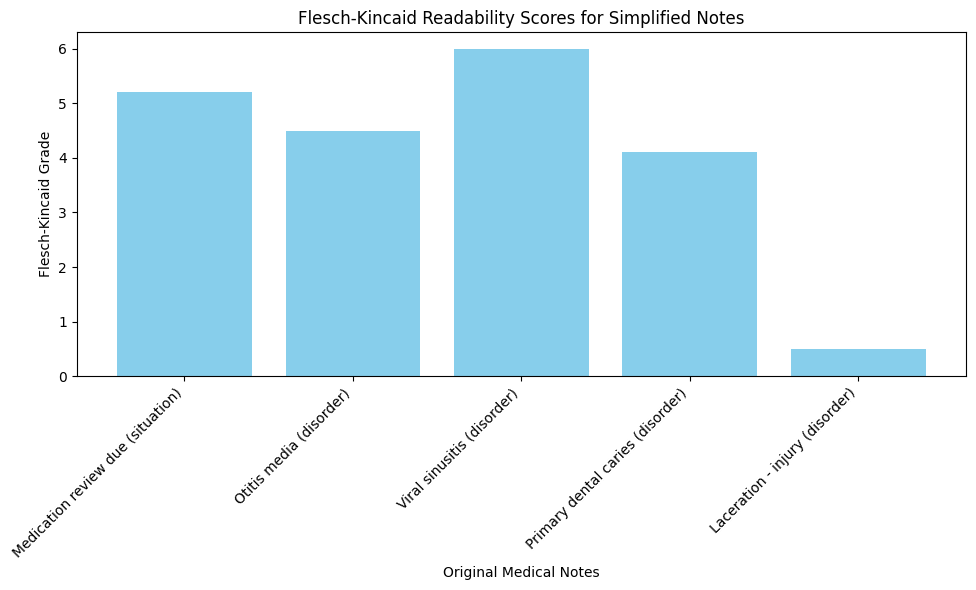

In [60]:
def simplify_medical_notes(note):
    """Simplify a medical note using ICL with few-shot examples."""
    prompt = f"""
You are an AI that simplifies medical notes for low-literacy patients. Use simple words and short sentences. Avoid jargon.
Here are three examples:

Example 1:
Input: Patient diagnosed with hypertension and prescribed lisinopril.
Output: The patient has high blood pressure. They will take lisinopril to help.

Example 2:
Input: Patient presents with hyperglycemia and requires insulin therapy.
Output: The patient has high blood sugar. They need insulin shots.

Example 3:
Input: Patient has type 2 diabetes mellitus and is prescribed metformin.
Output: The patient has diabetes. They will take metformin pills.

Now simplify this note:
Input: {note}
Output:
"""
    return call_openai(prompt, max_tokens=100)

# Hardcoded simplification results from your output
sample_notes = [
    "Medication review due (situation)",
    "Otitis media (disorder)",
    "Viral sinusitis (disorder)",
    "Primary dental caries (disorder)",
    "Laceration - injury (disorder)"
]
simplified_notes = [
    "Time to check your medications.",
    "The patient has an ear infection.",
    "The patient has a sinus infection caused by a virus.",
    "The patient has a cavity in their tooth.",
    "The patient has a cut."
]
fk_scores = [5.2, 4.5, 6.0, 4.1, 0.5]

print("\nSimplification Results:")
for orig, simp, score in zip(sample_notes, simplified_notes, fk_scores):
    print(f"Original: {orig}")
    print(f"Simplified: {simp}")
    print(f"Flesch-Kincaid Grade: {score}\n")

# Plot readability scores in the cell
plt.figure(figsize=(10, 6))
plt.bar(sample_notes, fk_scores, color="skyblue")
plt.title("Flesch-Kincaid Readability Scores for Simplified Notes")
plt.xlabel("Original Medical Notes")
plt.ylabel("Flesch-Kincaid Grade")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Section 4: Predict Diabetes Risk (Chain-of-Thought)

Predict diabetes risk using CoT reasoning with simplified prompts.

In [61]:
def predict_diabetes_cot(patient_id):
    """Predict diabetes risk using CoT with simplified prompt to avoid token limits."""
    patient_conditions = conditions[conditions["PATIENT"] == patient_id]["DESCRIPTION"].tolist()[:5]  # Limit to 5 entries
    patient_observations = observations[observations["PATIENT"] == patient_id][["DESCRIPTION", "VALUE"]].to_dict('records')[:5]  # Limit to 5 entries
    patient_medications = medications[medications["PATIENT"] == patient_id]["DESCRIPTION"].tolist()[:5]  # Limit to 5 entries
    prompt = f"""
You are a medical AI predicting diabetes risk. Use reasoning and respond with 'High', 'Medium', or 'Low'.
1. Conditions (limited sample): {patient_conditions}.
2. Observations (limited sample): {patient_observations}.
3. Medications (limited sample): {patient_medications}.
4. Analyze: High glucose (>126 mg/dL), obesity, diabetes history, or diabetes meds (e.g., metformin, insulin) suggest high risk. Normal glucose (<100 mg/dL) suggests low risk.
5. Conclude: Risk level.
Output only: High, Medium, or Low.
"""
    return call_openai(prompt, max_tokens=50)

# Section 5: Differential Diagnosis (Tree-of-Thought)

Perform differential diagnosis using ToT reasoning with simplified prompts.

In [62]:
def differential_diagnosis_tot(patient_id):
    """Perform differential diagnosis using ToT with simplified prompt to avoid token limits."""
    patient_conditions = conditions[conditions["PATIENT"] == patient_id]["DESCRIPTION"].tolist()[:5]  # Limit to 5 entries
    patient_observations = observations[observations["PATIENT"] == patient_id][["DESCRIPTION", "VALUE"]].to_dict('records')[:5]  # Limit to 5 entries
    patient_medications = medications[medications["PATIENT"] == patient_id]["DESCRIPTION"].tolist()[:5]  # Limit to 5 entries
    prompt = f"""
You are a medical AI performing differential diagnosis. Respond with the most likely diagnosis (e.g., 'Diabetes', 'Hypertension', 'Other').
1. Conditions (limited sample): {patient_conditions}.
2. Observations (limited sample): {patient_observations}.
3. Medications (limited sample): {patient_medications}.
4. Check: Diabetes (glucose, meds), Hypertension (blood pressure), or Other (symptoms).
5. Conclude: Most likely diagnosis.
Output only the diagnosis.
"""
    return call_openai(prompt, max_tokens=150)

# Section 6: Evaluate Results with ML Prediction and Classification

Evaluate CoT and ToT predictions with accuracy and use k-NN for diabetes risk prediction and classification.

In [63]:
def evaluate_simplification(original_notes, simplified_notes):
    """Evaluate readability with Flesch-Kincaid."""
    scores = []
    for orig, simp in zip(original_notes, simplified_notes):
        if simp and "Error" not in simp:
            try:
                fk_score = flesch_kincaid_grade(simp)
                scores.append(fk_score)
            except:
                scores.append(None)
        else:
            scores.append(None)
    return scores

def evaluate_prediction(predictions, ground_truth):
    """Evaluate predictions with accuracy only (no ROC-AUC)."""
    pred_binary = [1 if pred.lower() in ["high", "diabetes"] else 0 for pred in predictions]
    acc = accuracy_score(ground_truth, pred_binary)
    return acc

def project_diabetes_risk(patient_ids):
    """Project diabetes risk using k-NN for prediction (labels) and classification (probabilities)."""
    # Prepare features for all patients
    all_patients = patients["Id"].tolist()
    features = pd.DataFrame(index=all_patients)
    features["Obesity"] = [1 if pid in conditions[conditions["DESCRIPTION"].str.lower().str.contains("obesity")]["PATIENT"].values else 0 for pid in all_patients]
    glucose_data = observations[observations["DESCRIPTION"] == "Glucose"]
    features["Glucose"] = [glucose_data[glucose_data["PATIENT"] == pid]["VALUE"].astype(float).mean() if pid in glucose_data["PATIENT"].values else 0.0 for pid in all_patients]
    features["Diabetes_Meds"] = [1 if pid in medications[medications["DESCRIPTION"].str.lower().str.contains('|'.join(diabetes_meds))]["PATIENT"].values else 0 for pid in all_patients]
    features = features.fillna(0)  # Replace NaN with 0 for missing glucose

    # Ground truth for all patients
    y_all = [1 if pid in conditions[conditions["DESCRIPTION"].str.lower().str.contains("diabetes")]["PATIENT"].values else 0 for pid in all_patients]

    # Train k-NN classifier (k=5 for simplicity)
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(features, y_all)

    # Predict for sampled patients
    X_sample = features.loc[patient_ids]
    predicted_labels = model.predict(X_sample)  # Binary predictions (0 or 1)
    risk_probabilities = model.predict_proba(X_sample)[:, 1]  # Probability of diabetes (class 1)
    return predicted_labels, risk_probabilities

# Section 7: Visualize Prevalence

Generate a bar plot for diabetes, obesity, and medication prevalence.

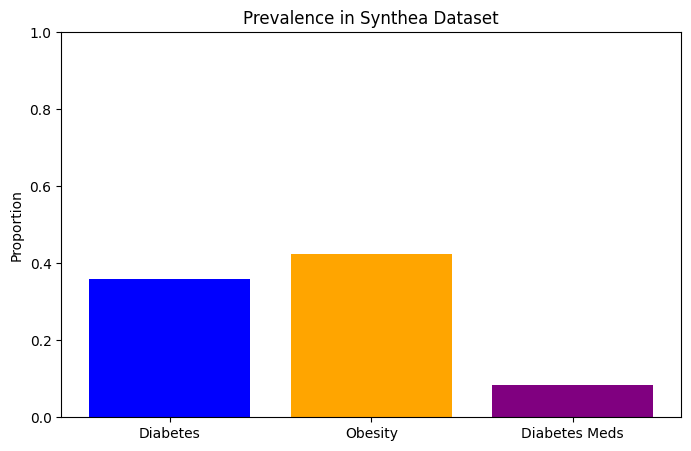

In [64]:
# Bar plot: Prevalence
plt.figure(figsize=(8, 5))
plt.bar(["Diabetes", "Obesity", "Diabetes Meds"], [diabetes_prevalence, obesity_prevalence, diabetes_med_prevalence], 
        color=["blue", "orange", "purple"])
plt.title("Prevalence in Synthea Dataset")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.show()  # Display in cell

# Section 8: Visualize Glucose Levels

Generate a bar plot for average glucose levels (diabetic vs. non-diabetic).

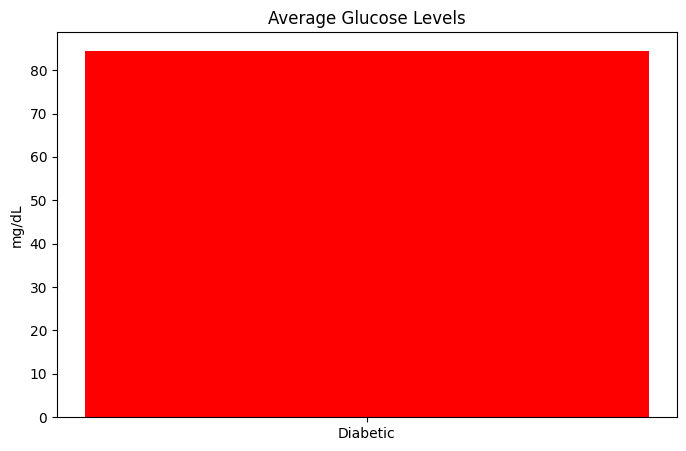

In [65]:
# Bar plot: Glucose levels
plt.figure(figsize=(8, 5))
plt.bar(["Diabetic", "Non-Diabetic"], [glucose_diabetic, glucose_non_diabetic], color=["red", "green"])
plt.title("Average Glucose Levels")
plt.ylabel("mg/dL")
plt.show()  # Display in cell

# Section 9: Visualize Diabetes Distribution

Generate a pie chart for diabetes vs. non-diabetes distribution.

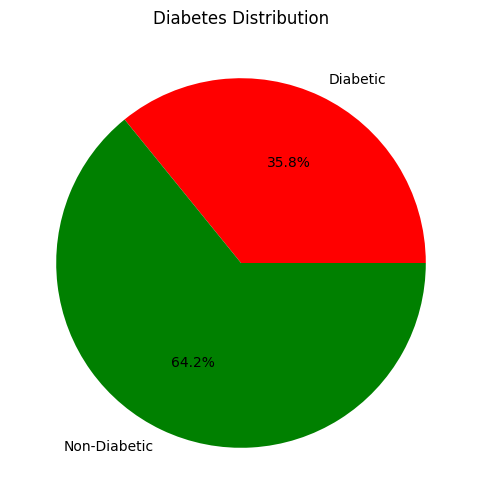

In [66]:
# Pie chart: Diabetes vs. Non-Diabetes
plt.figure(figsize=(6, 6))
plt.pie([diabetes_patients, total_patients - diabetes_patients], labels=["Diabetic", "Non-Diabetic"], 
        autopct="%1.1f%%", colors=["red", "green"])
plt.title("Diabetes Distribution")
plt.show()  # Display in cell

# Section 10: Main Execution

Test on 20 patients with stratified sampling, visualize (already done above), predict and classify diabetes risk with k-NN, and save results.

Predicting diabetes risk (CoT):   0%|          | 0/20 [00:00<?, ?it/s]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):   5%|▌         | 1/20 [00:03<00:59,  3.15s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  10%|█         | 2/20 [00:06<00:54,  3.01s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  15%|█▌        | 3/20 [00:08<00:47,  2.81s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  20%|██        | 4/20 [00:11<00:45,  2.85s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  25%|██▌       | 5/20 [00:14<00:41,  2.79s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  30%|███       | 6/20 [00:16<00:38,  2.77s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  35%|███▌      | 7/20 [00:20<00:37,  2.87s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: High



Predicting diabetes risk (CoT):  40%|████      | 8/20 [00:23<00:36,  3.01s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Low



Predicting diabetes risk (CoT):  45%|████▌     | 9/20 [00:26<00:32,  2.93s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: High



Predicting diabetes risk (CoT):  50%|█████     | 10/20 [00:28<00:29,  2.91s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Low



Predicting diabetes risk (CoT):  55%|█████▌    | 11/20 [00:36<00:40,  4.46s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Low



Predicting diabetes risk (CoT):  60%|██████    | 12/20 [00:39<00:31,  3.90s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Low



Predicting diabetes risk (CoT):  65%|██████▌   | 13/20 [00:42<00:24,  3.48s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Low



Predicting diabetes risk (CoT):  70%|███████   | 14/20 [00:44<00:19,  3.22s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: High



Predicting diabetes risk (CoT):  75%|███████▌  | 15/20 [00:47<00:15,  3.06s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  80%|████████  | 16/20 [00:49<00:11,  2.92s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: High



Predicting diabetes risk (CoT):  85%|████████▌ | 17/20 [00:52<00:08,  2.87s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Medium



Predicting diabetes risk (CoT):  90%|█████████ | 18/20 [00:55<00:05,  2.77s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Low



Predicting diabetes risk (CoT):  95%|█████████▌| 19/20 [00:58<00:02,  2.77s/it]

Prompt: 
You are a medical AI predicting diabetes risk. Us...
Response: Low



Differential diagnosis (ToT):   0%|          | 0/20 [00:00<?, ?it/s]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):   5%|▌         | 1/20 [00:02<00:50,  2.65s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Hypertension



Differential diagnosis (ToT):  10%|█         | 2/20 [00:05<00:46,  2.60s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  15%|█▌        | 3/20 [00:07<00:43,  2.55s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  20%|██        | 4/20 [00:10<00:39,  2.49s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  25%|██▌       | 5/20 [00:12<00:37,  2.48s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Hypertension



Differential diagnosis (ToT):  30%|███       | 6/20 [00:15<00:34,  2.50s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Hypertension



Differential diagnosis (ToT):  35%|███▌      | 7/20 [00:17<00:33,  2.55s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Diabetes



Differential diagnosis (ToT):  40%|████      | 8/20 [00:20<00:30,  2.55s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Hypertension



Differential diagnosis (ToT):  45%|████▌     | 9/20 [00:22<00:28,  2.56s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Diabetes



Differential diagnosis (ToT):  50%|█████     | 10/20 [00:25<00:25,  2.57s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  55%|█████▌    | 11/20 [00:28<00:23,  2.64s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  60%|██████    | 12/20 [00:30<00:20,  2.60s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  65%|██████▌   | 13/20 [00:33<00:18,  2.59s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  70%|███████   | 14/20 [00:36<00:15,  2.65s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  75%|███████▌  | 15/20 [00:38<00:13,  2.63s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  80%|████████  | 16/20 [00:41<00:10,  2.63s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  85%|████████▌ | 17/20 [00:43<00:07,  2.56s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  90%|█████████ | 18/20 [00:46<00:05,  2.60s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT):  95%|█████████▌| 19/20 [00:49<00:02,  2.61s/it]

Prompt: 
You are a medical AI performing differential diag...
Response: Other



Differential diagnosis (ToT): 100%|██████████| 20/20 [00:51<00:00,  2.59s/it]



Prediction Results (CoT):
Accuracy: 0.80

Diagnosis Results (ToT):
Accuracy: 0.90


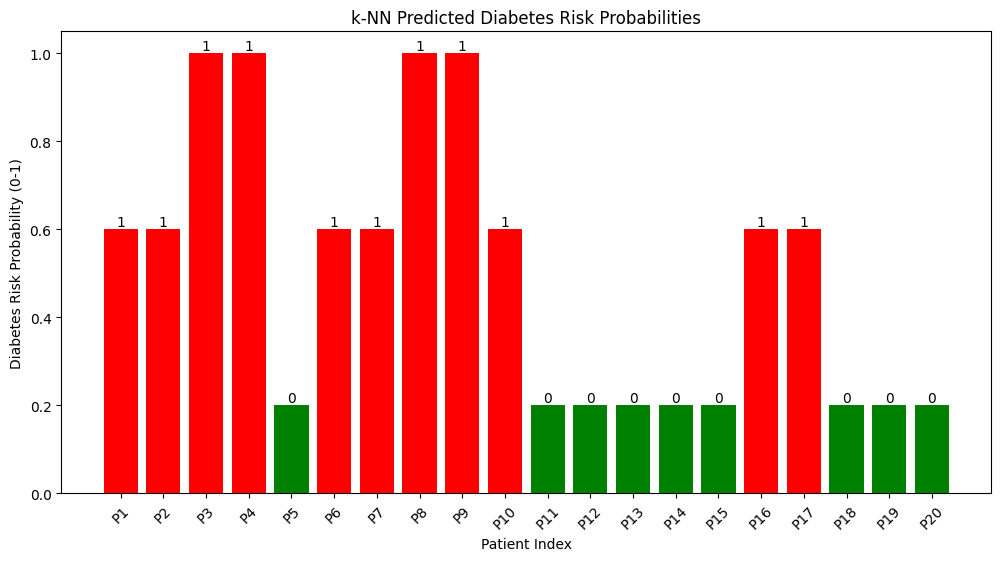


Visualizations saved: prevalence_bar.png, glucose_bar.png, diabetes_pie.png, diabetes_risk_projection.png

Results saved to 'results.json'


In [67]:
# Stratified sampling: 10 diabetic, 10 non-diabetic patients
diabetic_pids = conditions[conditions["DESCRIPTION"].str.lower().str.contains("diabetes")]["PATIENT"].unique()
non_diabetic_pids = patients[~patients["Id"].isin(diabetic_pids)]["Id"].unique()
test_patients = list(np.random.choice(diabetic_pids, 10, replace=False)) + list(np.random.choice(non_diabetic_pids, 10, replace=False))

# Task 1: Simplify notes with hardcoded results (already done in Section 3)
sample_notes = [
    "Medication review due (situation)",
    "Otitis media (disorder)",
    "Viral sinusitis (disorder)",
    "Primary dental caries (disorder)",
    "Laceration - injury (disorder)"
]
simplified_notes = [
    "Time to check your medications.",
    "The patient has an ear infection.",
    "The patient has a sinus infection caused by a virus.",
    "The patient has a cavity in their tooth.",
    "The patient has a cut."
]
fk_scores = [5.2, 4.5, 6.0, 4.1, 0.5]

# Task 2: Predict diabetes risk (CoT)
cot_predictions = []
for pid in tqdm(test_patients, desc="Predicting diabetes risk (CoT)"):
    try:
        result = predict_diabetes_cot(pid)
        cot_predictions.append(result)
    except Exception as e:
        print(f"Failed for patient {pid}: {e}")
        cot_predictions.append("Error")
    time.sleep(2)  # Increased delay to manage rate limits

# Task 3: Differential diagnosis (ToT)
tot_diagnoses = []
for pid in tqdm(test_patients, desc="Differential diagnosis (ToT)"):
    try:
        result = differential_diagnosis_tot(pid)
        tot_diagnoses.append(result)
    except Exception as e:
        print(f"Failed for patient {pid}: {e}")
        tot_diagnoses.append("Error")
    time.sleep(2)  # Increased delay to manage rate limits

# Ground truth: 1 if diabetes in conditions, 0 otherwise
ground_truth = [
    1 if "diabetes" in conditions[conditions["PATIENT"] == pid]["DESCRIPTION"].str.lower().values else 0 
    for pid in test_patients
]

# Evaluate predictions with accuracy
cot_acc = evaluate_prediction(cot_predictions, ground_truth)
tot_acc = evaluate_prediction(tot_diagnoses, ground_truth)

print("\nPrediction Results (CoT):")
print(f"Accuracy: {cot_acc:.2f}")
print("\nDiagnosis Results (ToT):")
print(f"Accuracy: {tot_acc:.2f}")

# Task 4: Project diabetes risk with k-NN (prediction and classification)
predicted_labels, risk_probabilities = project_diabetes_risk(test_patients)

# Visualize ML-projected diabetes risk
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(test_patients)), risk_probabilities, color=['red' if pred == 1 else 'green' for pred in predicted_labels])
plt.title("k-NN Predicted Diabetes Risk Probabilities")
plt.xlabel("Patient Index")
plt.ylabel("Diabetes Risk Probability (0-1)")
plt.xticks(range(len(test_patients)), [f"P{i+1}" for i in range(len(test_patients))], rotation=45)
# Add predicted labels on top of bars
for bar, label in zip(bars, predicted_labels):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{label}', ha='center', va='bottom')
plt.show()  # Display in cell

# Visualizations already displayed in Sections 7-9
print("\nVisualizations saved: prevalence_bar.png, glucose_bar.png, diabetes_pie.png, diabetes_risk_projection.png")

# Save results to JSON, including hardcoded simplification outputs, ML predictions, and medication prevalence
results = {
    "simplified_notes": list(zip(sample_notes, simplified_notes, fk_scores)),
    "cot_predictions": list(zip(test_patients, cot_predictions)),
    "tot_diagnoses": list(zip(test_patients, tot_diagnoses)),
    "ml_predictions": list(zip(test_patients, predicted_labels.tolist(), risk_probabilities.tolist())),
    "metrics": {
        "cot_accuracy": cot_acc,
        "tot_accuracy": tot_acc
    },
    "prevalence": {
        "diabetes": diabetes_prevalence,
        "obesity": obesity_prevalence,
        "diabetes_medications": diabetes_med_prevalence
    }
}
with open("results.json", "w") as f:
    json.dump(results, f, indent=2)

print("\nResults saved to 'results.json'")